In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

import tensorflow as tf
from collections import Counter

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import cross_validate

from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model

import wandb
from wandb.keras import WandbCallback

2023-05-20 15:06:15.466091: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


The purpose of this notebook is to cluster images with k-means and gaussian mixture models.
Here an overview to the steps in the notebook:
1. Generate embeddings: get a numerical representation for every image
2. Clustering: group images such that similar ones are close together, use K-Means and Gaussian Mixture models
3. Visualize images in every cluster to get a feeling for them

## Generate embeddings

In [2]:
# Set paths
path_train_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_filenames.npy'
path_train_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_labels.npy'
path_val_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_filenames.npy'
path_val_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_labels.npy'
path_test_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_filenames.npy'
path_test_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_labels.npy'

# Load Data
train_filenames_array = np.load(path_train_filenames_array)
train_labels_array = np.load(path_train_labels_array)
val_filenames_array = np.load(path_val_filenames_array)
val_labels_array = np.load(path_val_labels_array)
test_filenames_array = np.load(path_test_filenames_array)
test_labels_array = np.load(path_test_labels_array)

train_filenames = train_filenames_array.tolist()
train_labels = train_labels_array.tolist()
val_filenames = val_filenames_array.tolist()
val_labels = val_labels_array.tolist()
test_filenames = test_filenames_array.tolist()
test_labels = test_labels_array.tolist()

IMG_SIZE = 150
BATCH_SIZE = 128

def process_function(filename, label, img_height = IMG_SIZE, img_width = IMG_SIZE):
    img = tf.io.read_file(filename)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (img_height, img_width))
    return img

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), tf.constant(train_labels)))
train_data = train_data.map(process_function)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), tf.constant(val_labels)))
val_data = val_data.map(process_function)
val_data = val_data.batch(BATCH_SIZE)
val_data = val_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_data = tf.data.Dataset.from_tensor_slices((tf.constant(test_filenames), tf.constant(test_labels)))
test_data = test_data.map(process_function)
test_data = test_data.batch(BATCH_SIZE)
test_data = test_data.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
base_model = tf.keras.applications.Xception(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = False

emb_generator = tf.keras.Sequential()
emb_generator.add(tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input, input_shape=IMG_SHAPE))
emb_generator.add(base_model)
emb_generator.add(tf.keras.layers.GlobalAveragePooling2D())
emb_generator.add(tf.keras.layers.Dense(512, activation='relu'))

emb_train = emb_generator.predict(train_data)
emb_val = emb_generator.predict(val_data)
emb_test = emb_generator.predict(test_data)

path_train_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_embeddings.npy'
path_val_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_embeddings.npy'
path_test_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_embeddings.npy'

np.save(path_train_embeddings_array, emb_train)
np.save(path_val_embeddings_array, emb_val)
np.save(path_test_embeddings_array, emb_test)

## Clustering

In [ ]:
path_train_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_embeddings.npy'
path_val_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_embeddings.npy'
path_test_embeddings_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_embeddings.npy'
emb_train = np.load(path_train_embeddings_array)
emb_val = np.load(path_val_embeddings_array)
emb_test = np.load(path_test_embeddings_array)

### K-Means
Find optimal number of clusters for k-means with elbow method

In [ ]:
##find optimal number of clusters
wcss = []
data = np.vstack((emb_train, emb_val, emb_test))
for i in range(1, 20):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit(data)
    wcss.append(clustering.inertia_)
    
ks = np.arange(1, 40, 1)
plt.plot(ks, wcss)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Clusters Sum of Squares)')
plt.title('Elbow Method')
plt.savefig('/fig/elbow_plot_clustering.png', dpi = 200)
plt.show()

In [16]:
kmeans = KMeans(n_clusters=10, random_state=0, n_init="auto")
kmeans.fit(np.vstack((emb_train, emb_val, emb_test)))
cl_labels_train = kmeans.predict(emb_train)
cl_labels_val = kmeans.predict(emb_val)
cl_labels_test = kmeans.predict(emb_test)

path_train_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_cl_labels.npy'
path_val_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_cl_labels.npy'
path_test_cl_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels.npy'

np.save(path_train_cl_labels_array, cl_labels_train)
np.save(path_val_cl_labels_array, cl_labels_val)
np.save(path_test_cl_labels_array, cl_labels_test)

#### Gaussian Mixture Models for clustering

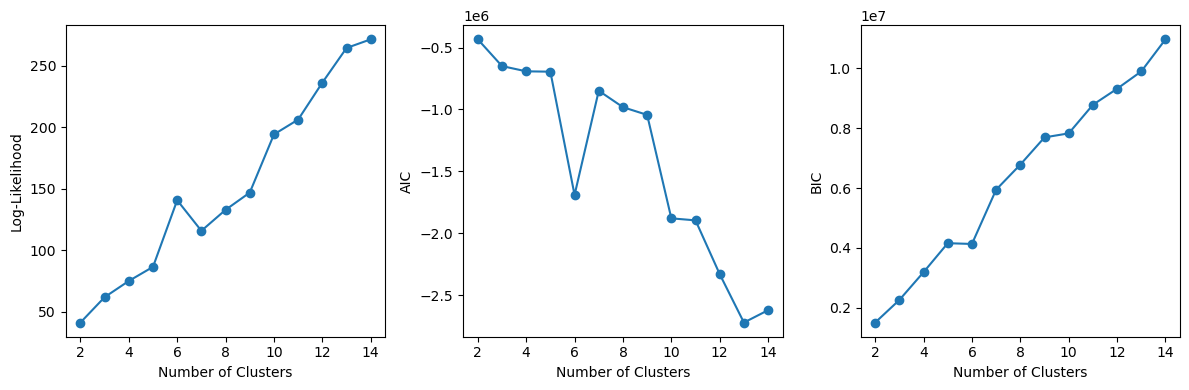

In [38]:
# Fit GMM models with different numbers of clusters
n_clusters = range(2, 15)
models = [GaussianMixture(n, random_state=0).fit(emb_train) for n in n_clusters]

# Calculate log-likelihood, AIC, and BIC for each model
log_likelihoods = [model.score(emb_train) for model in models]
aic = [model.aic(emb_train) for model in models]
bic = [model.bic(emb_train) for model in models]

# Plotting log-likelihood, AIC, and BIC against the number of clusters
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(n_clusters, log_likelihoods, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('Log-Likelihood')

plt.subplot(1, 3, 2)
plt.plot(n_clusters, aic, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('AIC')

plt.subplot(1, 3, 3)
plt.plot(n_clusters, bic, '-o')
plt.xlabel('Number of Clusters')
plt.ylabel('BIC')

plt.tight_layout()
plt.show()

In [22]:
gm = GaussianMixture(n_components=10, random_state=0)
gm.fit(np.vstack((emb_train, emb_val, emb_test)))

cl_labels_gm_train = gm.predict(emb_train)
cl_labels_gm_val = gm.predict(emb_val)
cl_labels_gm_test = gm.predict(emb_test)

path_train_cl_labels_gm_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_cl_labels_gm.npy'
path_val_cl_labels_gm_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_val_cl_labels_gm.npy'
path_test_cl_labels_gm_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_test_cl_labels_gm.npy'

np.save(path_train_cl_labels_gm_array, cl_labels_gm_train)
np.save(path_val_cl_labels_gm_array, cl_labels_gm_val)
np.save(path_test_cl_labels_gm_array, cl_labels_gm_test)

## Visualize embeddings
Sample some images for every cluster to get a feeling what the cluster themes are

#### K-Means

In [34]:
path_train_cl_labels_km_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_cl_labels.npy'
cl_labels_km_train = np.load(path_train_cl_labels_km_array)
cl_labels_km = cl_labels_km_train.tolist()

path_train_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_filenames.npy'
train_filenames_array = np.load(path_train_filenames_array)
train_filenames = train_filenames_array.tolist()

path_train_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_labels.npy'
train_labels_array = np.load(path_train_labels_array)
train_labels = train_labels_array.tolist()

df_train_km = pd.DataFrame()
df_train_km['filename'] = train_filenames
df_train_km['labels'] = train_labels
df_train_km['cl_labels'] = cl_labels_km

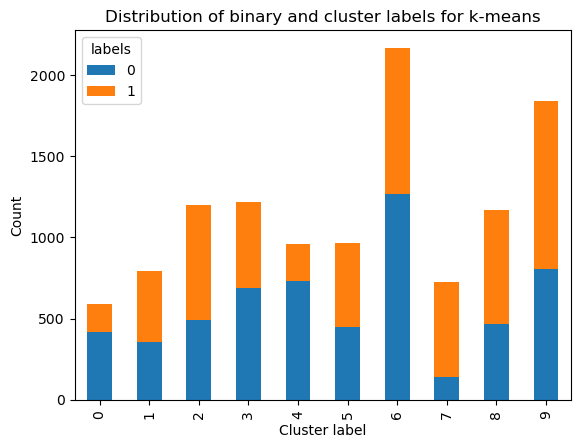

In [35]:
# create a pivot table to count the number of images for each label combination
pivot_table_km = df_train_km.pivot_table(index='cl_labels', columns='labels', values='filename', aggfunc='count')

# plot the stacked bar chart
pivot_table_km.plot(kind='bar', stacked=True)
plt.xlabel('Cluster label')
plt.ylabel('Count')
plt.title('Distribution of binary and cluster labels for k-means')
plt.show()

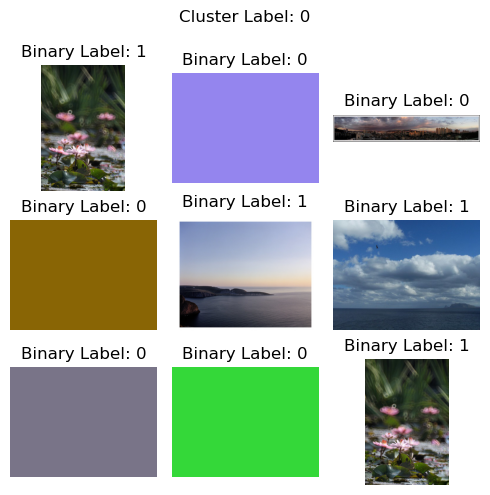

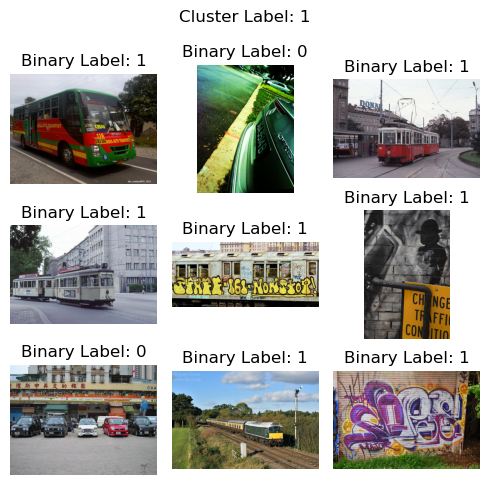

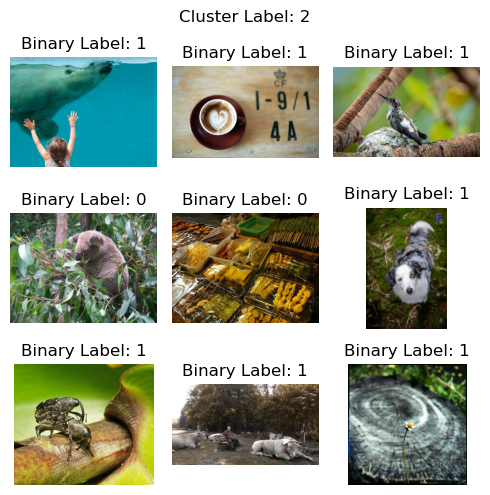

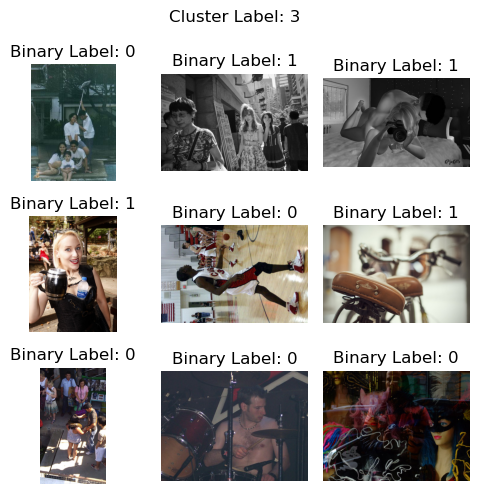

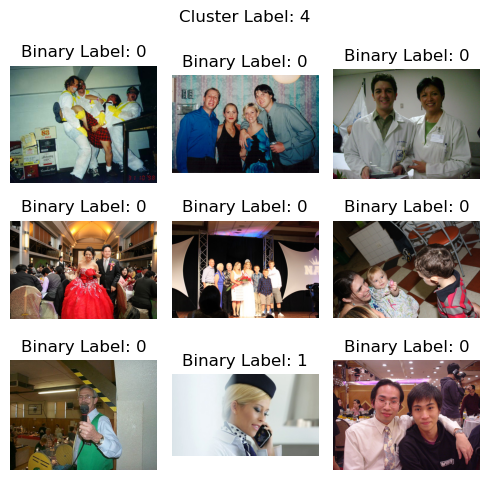

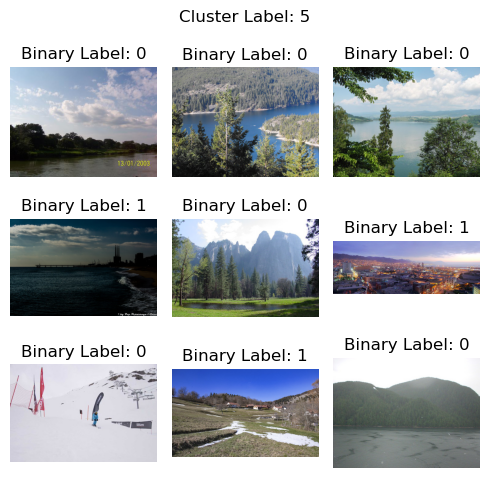

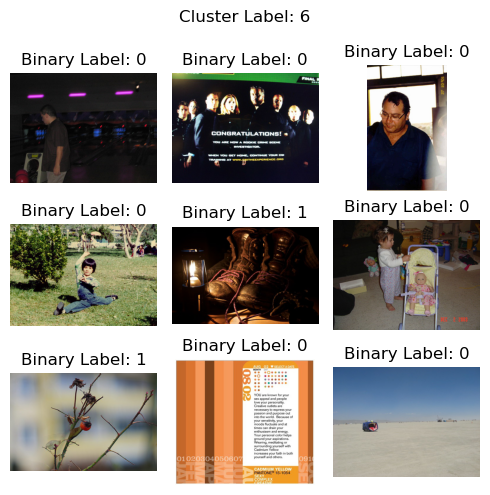

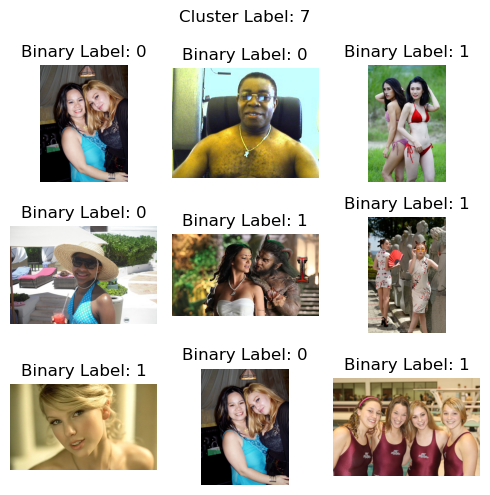

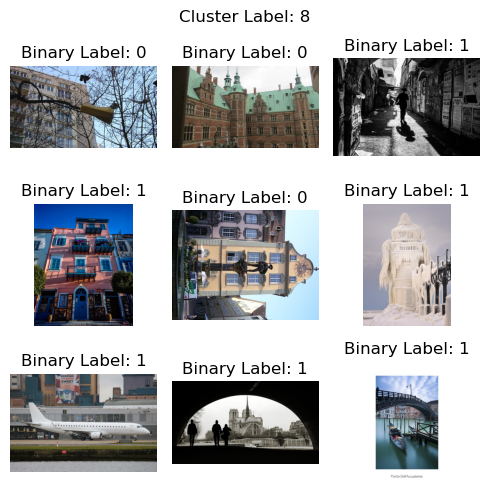

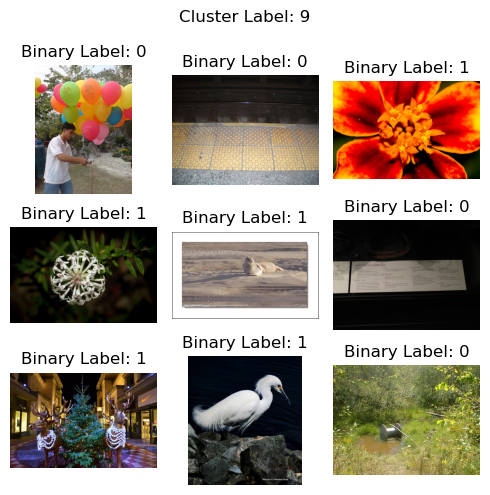

In [36]:
# group the dataframe by cluster label
grouped_df_km = df_train_km.groupby('cl_labels')

# loop through each cluster and plot 3 random images
for cluster_label, group in grouped_df_km:
    # randomly select up to 3 images from the group
    random_images = group.sample(n=9, replace=True)
    random_images = random_images.reset_index()

    # create a subplot grid for the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    fig.suptitle(f'Cluster Label: {cluster_label}')
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()

    # iterate through the randomly selected images
    for i, row in random_images.iterrows():
        image_path = row['filename']
        binary_label = row['labels']
        
        # plot the image on the corresponding subplot
        axes[i].imshow(plt.imread(image_path))
        axes[i].set_title(f'Binary Label: {binary_label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


### Gaussian mixture model

In [30]:
path_train_cl_labels_gm_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_cl_labels_gm.npy'
cl_labels_gm_train = np.load(path_train_cl_labels_gm_array)
cl_labels_gm = cl_labels_gm_train.tolist()

path_train_filenames_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_filenames.npy'
train_filenames_array = np.load(path_train_filenames_array)
train_filenames_ = train_filenames_array.tolist()

path_train_labels_array = '/nasdata/abdu/Learning2Rank/Flickr/data/FlickrFinal/top_train_labels.npy'
train_labels_array = np.load(path_train_labels_array)
train_labels = train_labels_array.tolist()

df_train_gm = pd.DataFrame()
df_train_gm['filename'] = train_filenames
df_train_gm['labels'] = train_labels
df_train_gm['cl_labels'] = cl_labels_gm

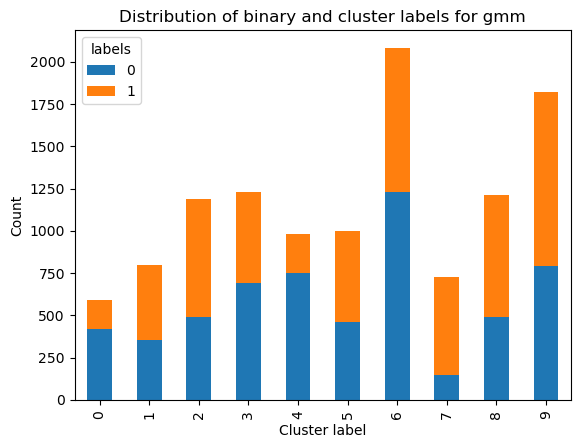

In [32]:
# create a pivot table to count the number of images for each label combination
pivot_table_gm = df_train_gm.pivot_table(index='cl_labels', columns='labels', values='filename', aggfunc='count')

# plot the stacked bar chart
pivot_table_gm.plot(kind='bar', stacked=True)
plt.xlabel('Cluster label')
plt.ylabel('Count')
plt.title('Distribution of binary and cluster labels for gmm')
plt.show()

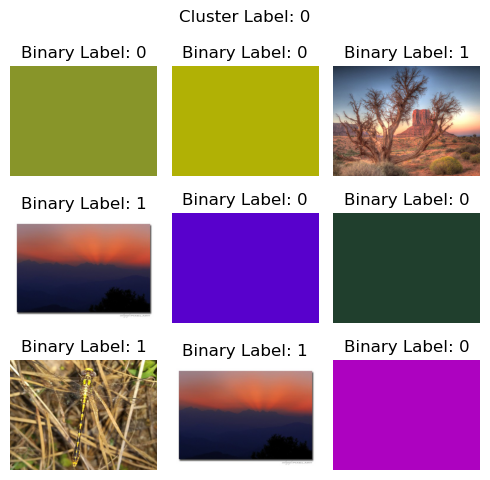

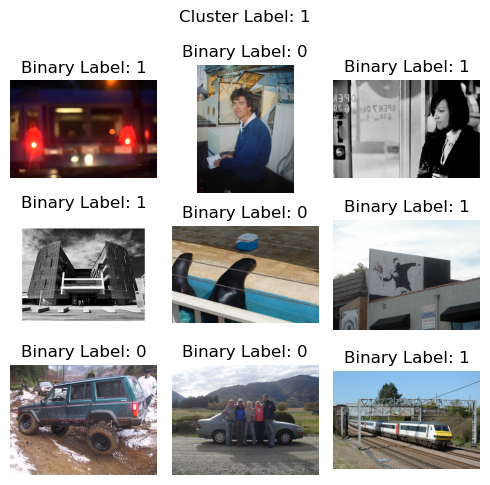

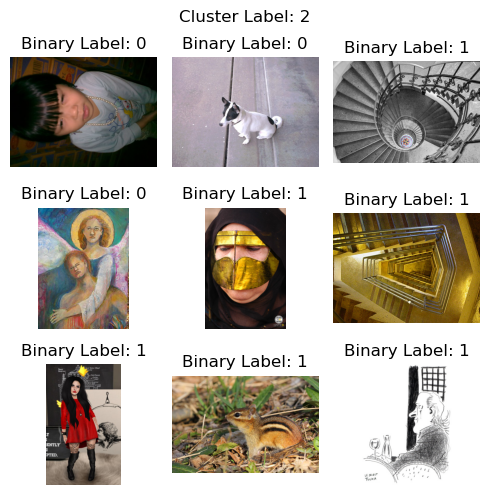

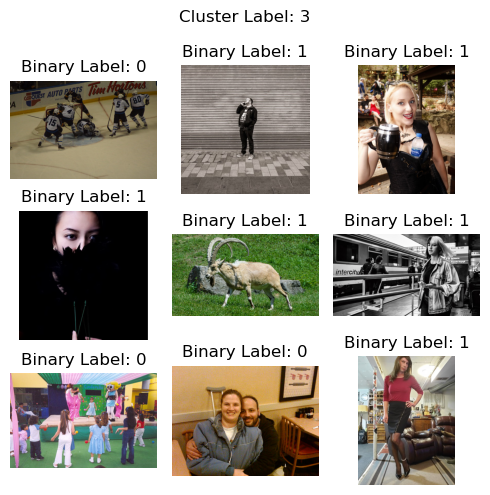

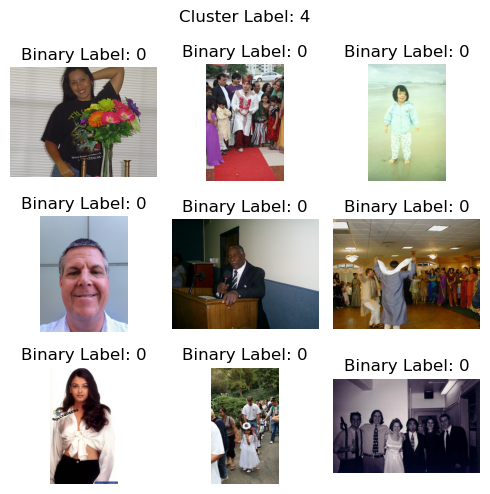

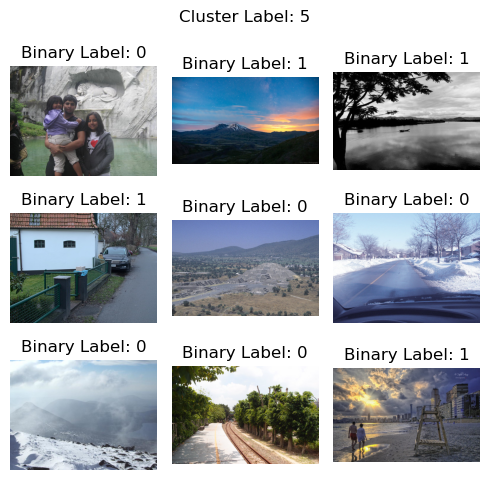

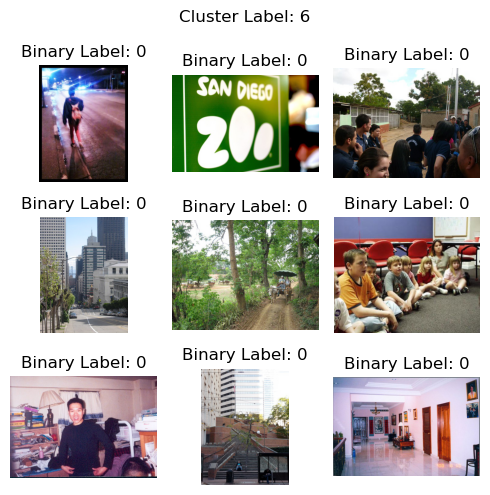

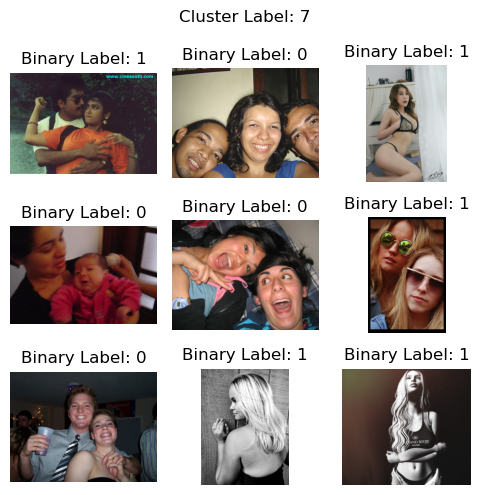

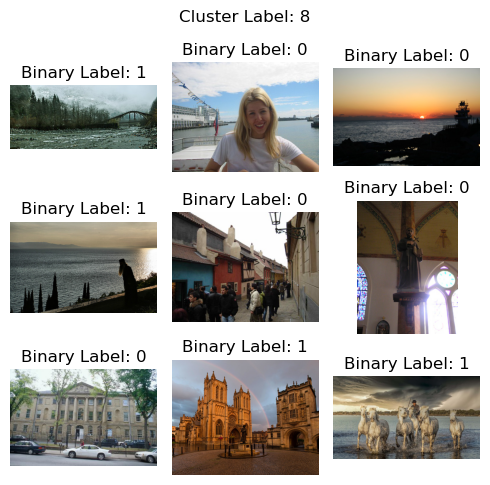

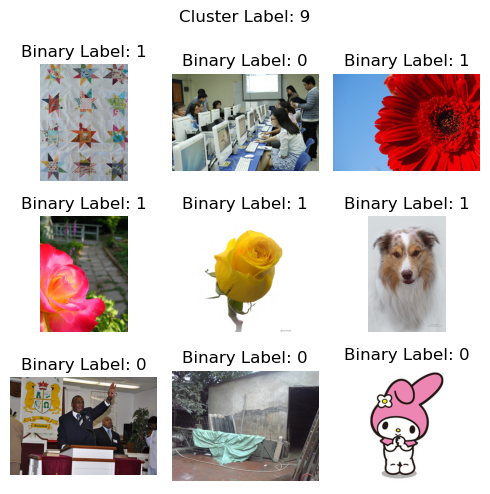

In [33]:
# group the dataframe by cluster label
grouped_df_gm = df_train_gm.groupby('cl_labels')

# loop through each cluster and plot 3 random images
for cluster_label, group in grouped_df_gm:
    # randomly select up to 3 images from the group
    random_images = group.sample(n=9, replace=True)
    random_images = random_images.reset_index()

    # create a subplot grid for the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))
    fig.suptitle(f'Cluster Label: {cluster_label}')
    
    # flatten the axes array for easy iteration
    axes = axes.flatten()

    # iterate through the randomly selected images
    for i, row in random_images.iterrows():
        image_path = row['filename']
        binary_label = row['labels']
        
        # plot the image on the corresponding subplot
        axes[i].imshow(plt.imread(image_path))
        axes[i].set_title(f'Binary Label: {binary_label}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()